# Course overview

> Getting started

In [2]:
from typing import List
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import numpy as np
import torch
from diffusers import AutoencoderKL, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer
import requests
from PIL import Image
from torchvision import transforms as tfms
from io import BytesIO

torch.cuda.empty_cache()

In [3]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Overview

https://course.fast.ai/Lessons/lesson9.html

Consider, we can have images at varying levels of bluriness.

In [4]:
mnist = load_dataset("mnist")
img = np.array(mnist["train"][0]["image"])
img = normalize(img)
img_blurry = img + np.random.normal(size=img.size).reshape(28, 28) * 0.2
img_very_blurry = img + np.random.normal(size=img.size).reshape(28, 28) * 0.8

Extracting data files: 100%|███████████████████████████████| 4/4 [00:00<00:00, 12.87it/s]


Dataset mnist downloaded and prepared to /home/ubuntu/.cache/huggingface/datasets/mnist/mnist/1.0.0/9d494b7f466d6931c64fb39d58bb1249a4d85c9eb9865d9bc20960b999e2a332. Subsequent calls will reuse this data.


100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00, 226.87it/s]


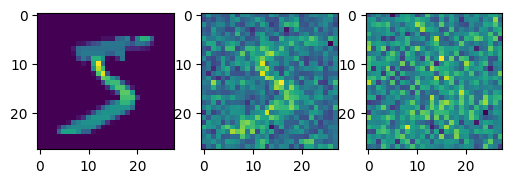

In [5]:
# |export
def show_images(imgs, titles=None, aspect_ratio=2):
    fig, axes = plt.subplots(
        1, len(imgs), figsize=(aspect_ratio * len(imgs), aspect_ratio)
    )
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if titles:
            ax.set(title=titles[i])
        ax.imshow(img)


imgs = [img, img_blurry, img_very_blurry]
show_images(imgs)

We can imagine a probability distribution over the image, which is a function, $P$, of $28^2$ variables (one for each pixel).

Recall that mutlivariate calculus is concerned with partial derivatives. For example, the partial derivatives of $f(x,y)=x^2 + y^2$ are:

$$
\begin{align}
\frac{\partial f(x,y)}{\partial x} &= 2x \\
\frac{\partial f(x,y)}{\partial y} &= 2y \\
\end{align}
$$

In the case of an image, imagine the partial derivative of the function $P$ with respect to a *single pixel*:

$$
\frac{\partial P(X)}{\partial X_{i,j}} = \frac{P(X)-P(X + \partial X_{i,j})}{\partial X_{i,j}}
$$

This gives us a way of altering the image from less likely and blurrier images to more likely and crisper images. An algorithm could look something like this:

- For all pixel values $X_{i,j} \in X$, evaluate the partial derivative $\frac{P(X)-P(X + \partial X_{i,j})}{\partial X_{i,j}}$ or $\frac{\partial P(X)}{\partial X_{i,j}}$. This can also be expressed as $\nabla_X P$
- For some hyperparameter constant $C$ and for all pixel values $X_{i,j} \in X$, $X_{i,j} := X_{i,j} + C \frac{\partial P(X)}{\partial X_{i,j}}$ or, equivalently, $X := X + C \cdot \nabla_X P$
- Repeat until satisfied

In PyTorch, this would look something like:

```python
X = get_image()
# Somewhat unusually, you would incorporate the image as a model
# parameter in order to get auto-differentiation
model = get_nabla_X_of_P_model(X=X)
for _ in range(n_timesteps):
	p_grad = model.forward(X)
	p_grad.backward()
	model.X += C * model.X.grad
```


In fact, we don't have $P(X)$ or $\nabla_X P(X)$ in real life. But we can solve a related problem.

Notice that $\nabla_X P(X)$ provides a direction from blurrier to sharper images. We can train a neural network to de-blur by adding the blur ourselves. The input-output pair would be $\langle image + \epsilon, \epsilon \rangle$ where $\epsilon \sim \mathcal{N}(0, \Sigma)$ and $\Sigma \in \mathbb{R}^{28^2 \times 28^2}$

## Noise Scheduling

Because Stable Diffusion originated in research in differential equations, we generally have $t$ as an input parameter. Different amounts of noise are added at different time steps.

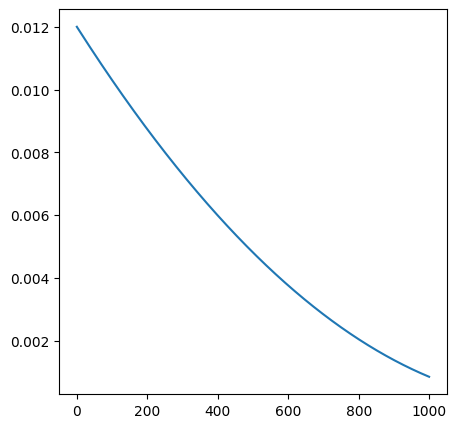

In [6]:
from diffusers import LMSDiscreteScheduler

scheduler = LMSDiscreteScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    num_train_timesteps=1000,
)
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(scheduler.timesteps, scheduler.betas)

Since the amount of noise is a function of time, giving the model access to $t$ can help its performance. Therefore, the input-output pair becomes  $\langle \left( image + \epsilon, t \right), \epsilon \rangle$.

This is similiar in many respects to gradient descent. We can think of $C$ as the learning rate; the principle difference is that the model would not have access to $t$.

## Prompt Conditioning

One thing we could add to make the problem easier is to indicate the image class (1, 2, 3, etc). For a simple class distribution, we could just one hot-encode it.  The input-output pair would then be $\langle \left( image + \epsilon, t, class \right), \epsilon \rangle$.

But we cannot one-hot encode the distribution of images on the internet à la Stable Diffusion. Therefore, we need a more sophisticated encoder: CLIP (**C**onstrastively **L**earned **I**mage **P**airs). This works on the idea that the dot-product between image encoding and text encoding of the *same thing* should be large, while the image encoding and text encoding for *different things* should be small.

We learn this with a neural network contrastively. For a given batch, $B$,  of (image, language) pairs from html `alt` tags:

- Compute the encoding $f_{image}(I_i)$ and $f_{language}(L_i)$ for all $i \in |B|$

- Compute the sum $\text{correctly paried loss} := \Sigma_i^{|B|} f_{image}(I_i) \cdot f_{language}(L_i)$

- Compute the sum

$$
\text{incorrectly paired loss} := \Sigma_i^{|B|} \Sigma_j^{|B|}  \begin{cases}
    f_{image}(I_i) \cdot f_{language}(L_j) & i \neq j\\
    0 & i = j
  \end{cases}
$$

- Final loss = `incorrectly paired loss` - `correctly paired loss`. Note that want the overall loss to be small or negative, so we take the negative of the sum of the correctly paired dot products. This pushes the vectors for correctly paired language image to be in the same subspace, and incorrectly paired counterparts into different subspaces.

![](../images/CLIP.jpg)

## VAE Pre-/post-processing

Another thing we can do is, instead of training directly on pixel values, use the latents of a Variational Autoencoder (VAE). This can give a dramatic reduction in the number of parameters to train.

In [7]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

In [13]:
#|export
to_tensor = tfms.ToTensor()

torch_device = "cuda" if torch.cuda.is_available() else "cpu"

VAE_TO_UNET_SCALING_FACTOR = 0.18215

def pil_to_latent(img, vae, device=torch_device):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    img = to_tensor(img).unsqueeze(0).to(device)
    img = img * 2 - 1 # Note scaling
    with torch.no_grad():
        latents = vae.encode(img)
    return VAE_TO_UNET_SCALING_FACTOR * latents.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / VAE_TO_UNET_SCALING_FACTOR) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def image_from_url(url, as_numpy=False):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    if as_numpy:
        return np.array(image)
    return image

def visualize_latents(img: Image.Image, vae) -> List[Image.Image]:
    img = to_tensor(img).unsqueeze(0).to(device)
    img = img * 2 - 1 # Note scaling
    with torch.no_grad():
        latents = vae.encode(img).latent_dist.sample()
    with torch.no_grad():
        image = vae.decode(latents).sample

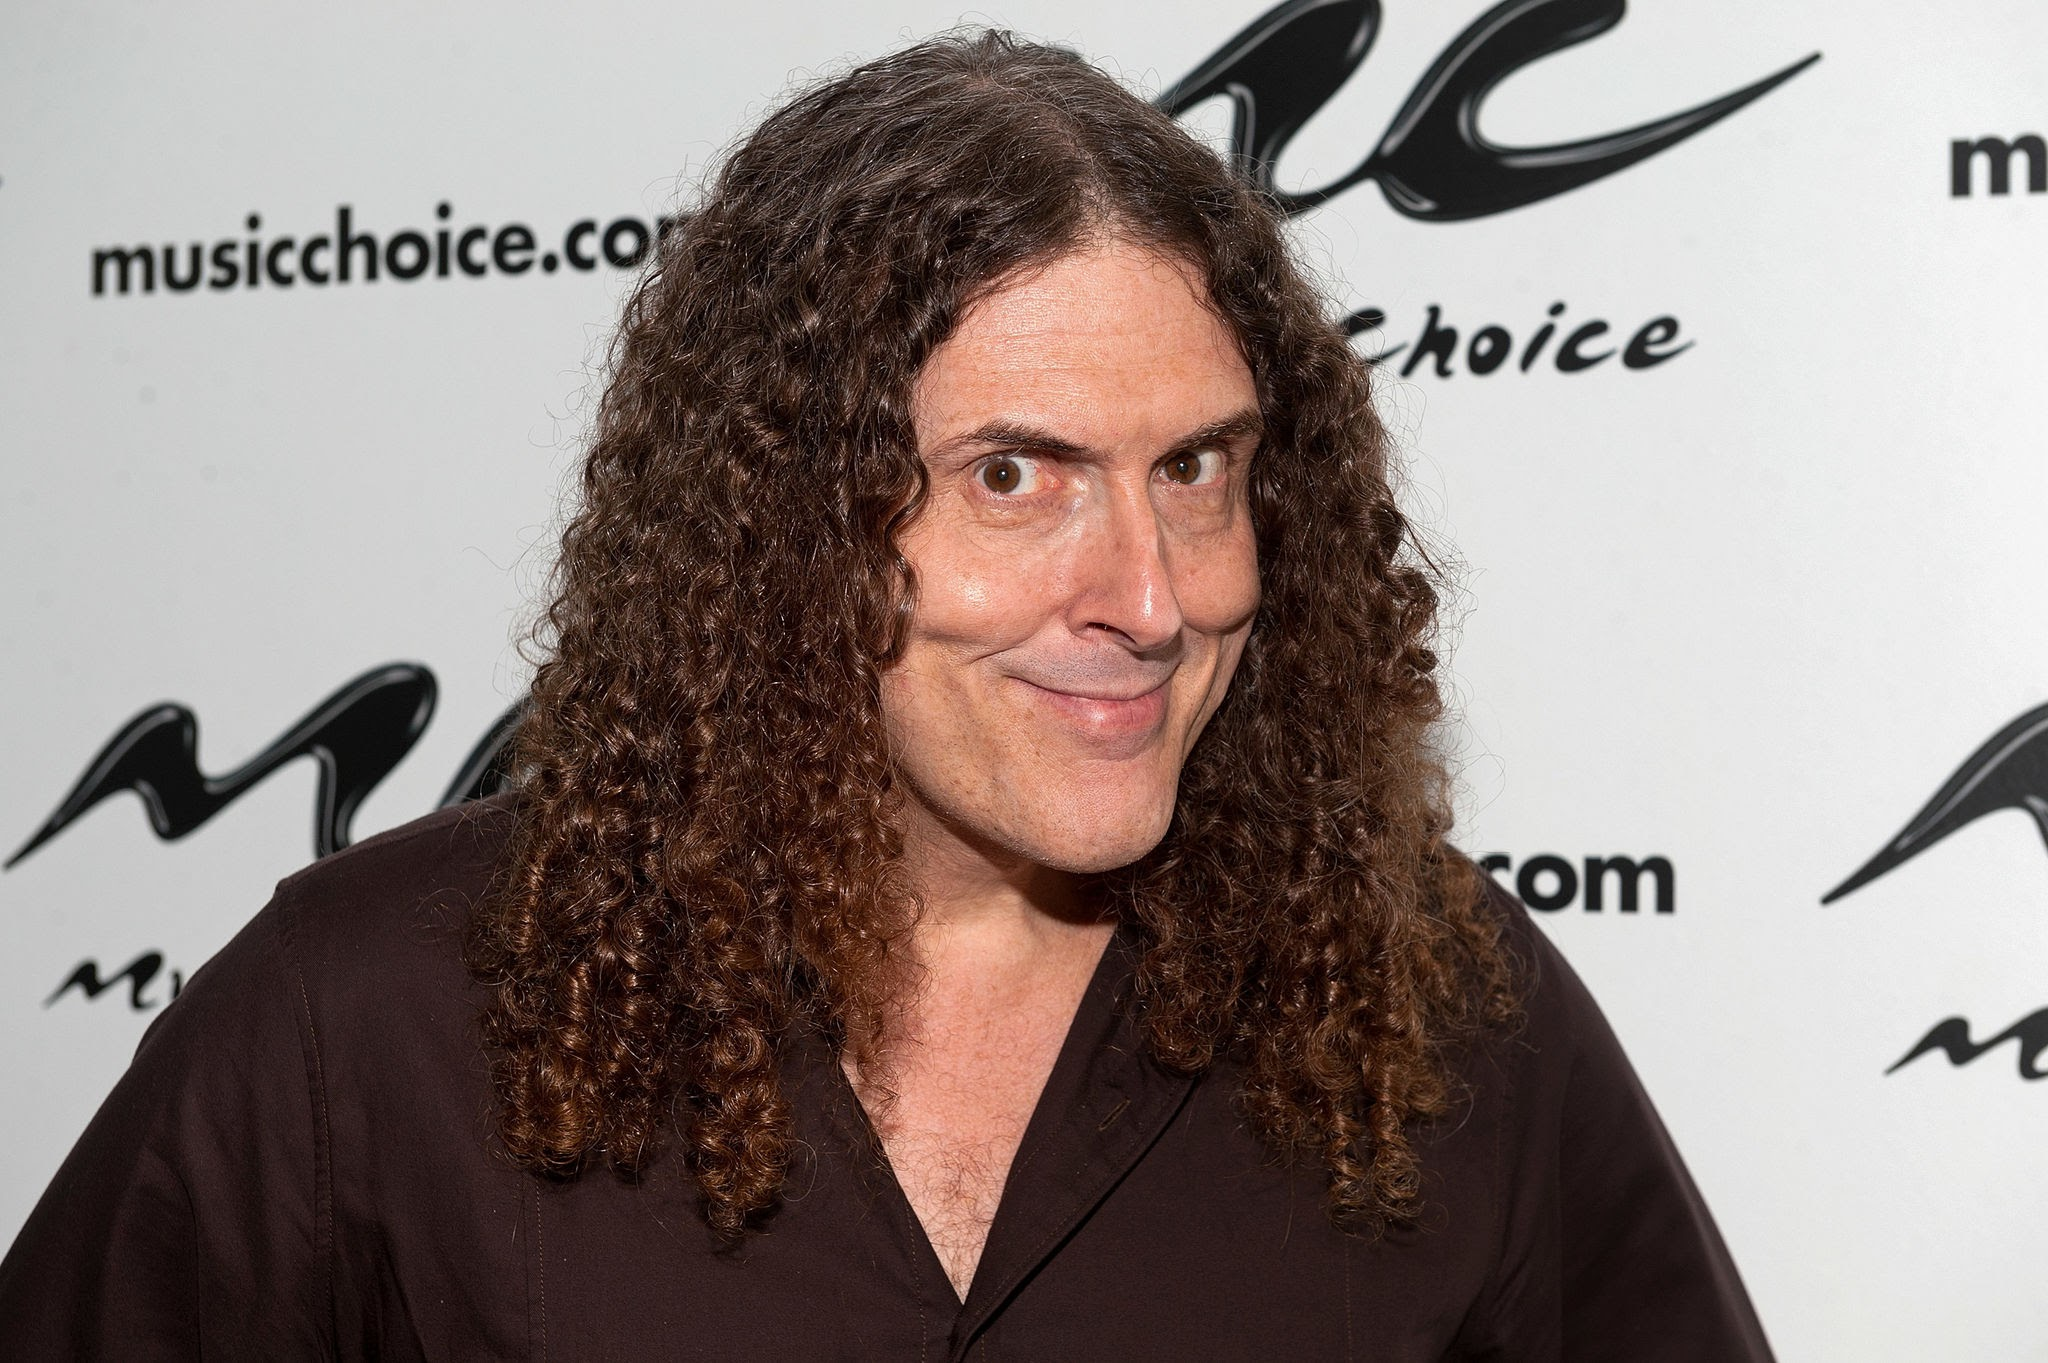

In [14]:
img = image_from_url(
    "https://encrypted-tbn0.gstatic.com/licensed-image?q=tbn:ANd9GcSIN4rQeUcHcQQFMmuzUHt8KoQ760kbhffEem2ftHKfIVS2m2G4hMC_mwdHr7asuxyiWovJvwJeuACMzdw"
)
img

In [ ]:
latents = pil_to_latent(img, vae)
imgs = latents_to_pil(latents)
show_images(imgs)